In [1]:
import numpy as np
import squigglepy as sq
import matplotlib.pyplot as plt

from pprint import pprint
from functools import partial
from typing import List, Tuple
from scipy.optimize import minimize, Bounds
from datetime import datetime, timedelta
from matplotlib.ticker import FuncFormatter


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)


def run_model(model, index_date=O3_LAUNCH_DATE):
    samples = sq.sample(model, n=100_000, verbose=True)
    pprint(sq.get_percentiles(samples, digits=0))
    print('\n-\n')
    samples_ = sq.get_percentiles(samples_to_date(samples, index_date=index_date))
    samples_ = {k: v.strftime("%Y %b %d") for k, v in samples_.items()}
    pprint(samples_)
    return samples


def samples_to_date(samples, index_date=O3_LAUNCH_DATE):
    date_converter = np.vectorize(lambda x: index_date + timedelta(days=int(np.ceil(x))))
    return date_converter(samples)


def calculate_doubling_time(start_task_length, agi_task_length, doubling_time, acceleration=1):
    """
    Parameters
    ----------
    start_task_length : scalar or distribution
        Current hours needed for the reference task.
    agi_task_length : scalar or distribution
        Hours required for the task at AGI.
    initial_doubling_time : scalar or distribution (days)
        Doubling time at the *current* capability level.
    acceleration : scalar or distribution
        Multiplicative factor applied to the doubling time *after every doubling*.
        • 1.0  → constant exponential growth (baseline).
        • <1.0 → doubling time shrinks, giving super‑exponential growth.
        • >1.0 → growth slows over time.
    """
    doublings_needed = sq.dist_log(agi_task_length / start_task_length) / np.log(2)
    if acceleration == 1:
        return doublings_needed * doubling_time
    else:
        return doubling_time * (1 - acceleration**doublings_needed) / (1 - acceleration)


def _pretty_time(hours: float) -> str:
    """Return a string with value + unit, choosing h / min / s."""
    if hours >= 1:
        return f"{hours:6.2f}hr"
    minutes = hours * 60
    if minutes >= 1:
        return f"{minutes:6.2f}min"
    seconds = minutes * 60
    return f"{seconds:6.0f}sec"
    

print('Loaded libraries')

Loaded libraries


In [2]:
def test_acceleration(
    start_task_length: float,
    agi_task_length: float,
    initial_doubling_time: float,
    acceleration: float = 1.0,
    start_date: str | datetime | None = None,
    date_fmt: str = "%Y‑%m‑%d",
):
    # Anchor date
    if start_date is None:
        start_date = datetime.today()
    elif isinstance(start_date, str):
        start_date = datetime.fromisoformat(start_date)

    current_task = start_task_length
    days_elapsed = 0.0
    tau = initial_doubling_time
    step = 0

    header = f"{'Step':>4} | {'Date':^10} | {'Day':>6} | {'Task':>10} | τ (d)"
    print(header)
    print("-" * len(header))

    while current_task < agi_task_length:
        date = start_date + timedelta(days=days_elapsed)
        print(f"{step:4d} | {date.strftime(date_fmt)} | "
              f"{int(days_elapsed):6d} | {_pretty_time(current_task):>10} | {tau:5.1f}")

        current_task *= 2            # actual doubling
        days_elapsed += tau
        tau *= acceleration          # super‑/sub‑exponential effect
        step += 1

    # final line after exceeding target
    date = start_date + timedelta(days=days_elapsed)
    print(f"{step:4d} | {date.strftime(date_fmt)} | "
          f"{int(days_elapsed):6d} | {_pretty_time(current_task):>10} | {tau:5.1f}  <-- reached target")


test_acceleration(
    start_task_length=2/60/60, # GPT2
    agi_task_length=167, 
    initial_doubling_time=260,
    acceleration=0.95,
    start_date="2019-02-14", # GPT2
)

Step |    Date    |    Day |       Task | τ (d)
-----------------------------------------------
   0 | 2019‑02‑14 |      0 |       2sec | 260.0
   1 | 2019‑11‑01 |    260 |       4sec | 247.0
   2 | 2020‑07‑05 |    507 |       8sec | 234.6
   3 | 2021‑02‑24 |    741 |      16sec | 222.9
   4 | 2021‑10‑05 |    964 |      32sec | 211.8
   5 | 2022‑05‑05 |   1176 |    1.07min | 201.2
   6 | 2022‑11‑22 |   1377 |    2.13min | 191.1
   7 | 2023‑06‑01 |   1568 |    4.27min | 181.6
   8 | 2023‑11‑30 |   1750 |    8.53min | 172.5
   9 | 2024‑05‑20 |   1922 |   17.07min | 163.9
  10 | 2024‑10‑31 |   2086 |   34.13min | 155.7
  11 | 2025‑04‑05 |   2242 |     1.14hr | 147.9
  12 | 2025‑08‑31 |   2390 |     2.28hr | 140.5
  13 | 2026‑01‑18 |   2530 |     4.55hr | 133.5
  14 | 2026‑06‑01 |   2664 |     9.10hr | 126.8
  15 | 2026‑10‑05 |   2790 |    18.20hr | 120.5
  16 | 2027‑02‑03 |   2911 |    36.41hr | 114.4
  17 | 2027‑05‑28 |   3025 |    72.82hr | 108.7
  18 | 2027‑09‑14 |   3134 |   145.64hr 

In [3]:
def calendar_days_for_doublings(
    doublings: np.ndarray,
    initial_doubling_time: float,
    acceleration: float
) -> np.ndarray:
    """Super‑exponential growth law from Chin & You (2024)."""
    if np.isclose(acceleration, 1.0):
        # pure exponential (constant doubling time)
        return doublings * initial_doubling_time
    return (
        initial_doubling_time
        * (1 - acceleration ** doublings)
        / (1 - acceleration)
    )


def estimate_growth_parameters(
    observations: List[Tuple[str, datetime, float]],
    baseline_date: datetime | None = None,
    baseline_task_hours: float | None = None,
) -> Tuple[float, float]:
    """
    Returns (τ₀, α) where
        τ₀ = initial doubling time (days at baseline capability)
        α  = multiplicative change in τ after each doubling
    """
    if baseline_date is None:
        baseline_date = observations[0][1]
    if baseline_task_hours is None:
        baseline_task_hours = observations[0][2]

    doublings: np.ndarray = np.log(
        [hours / baseline_task_hours for _, _, hours in observations]
    ) / np.log(2)

    elapsed_days: np.ndarray = np.array(
        [(release_date - baseline_date).days for _, release_date, _ in observations],
        dtype=float,
    )

    def mse_loss(theta: np.ndarray) -> float:
        τ0, α = theta
        if τ0 <= 0 or not 0 < α < 2:
            return np.inf  # penalise nonsense regions
        prediction = calendar_days_for_doublings(doublings, τ0, α)
        return np.mean((prediction - elapsed_days) ** 2)

    initial_guess = np.array([260.0, 0.95])
    bounds = Bounds([1e-6, 0.9], [np.inf, 1.0]) # # bound acceleration to 0.9-1, days must be positive
    result = minimize(mse_loss, x0=(260.0, 0.95), method="L-BFGS-B", bounds=bounds, options={"maxiter": 10_000})
    t_hat, a_hat = result.x
    return round(float(t_hat)), round(float(a_hat), 3)


def print_estimation(data):
    start_model = data[0][0]
    end_model = data[-1][0]
    print(f"{start_model} to {end_model}: {estimate_growth_parameters(data)}")
    return None


observed_models: List[Tuple[str, datetime, float]] = [
    # model                       # release date         # task length
    ("GPT‑2",                     datetime(2019, 2, 14),  2/3600),   # 2 s
    ("GPT‑3.5 Turbo",             datetime(2023, 6, 13), 36/3600),   # 36 s
    ("Claude 3 Opus",             datetime(2024, 3,  4),  6/60),     # 6 min
    ("GPT‑4o",                    datetime(2024, 5, 13),  9/60),     # 9 min
    ("Claude 3.5 Sonnet (old)",   datetime(2024, 6, 20), 18/60),     # 18 min
    ("o1 preview",                datetime(2024, 9, 12), 22/60),     # 22 min
    ("Claude 3.5 Sonnet (new)",   datetime(2024,10, 22), 28/60),     # 28 min
    ("o1",                        datetime(2024,12,  5), 39/60),     # 39 min
    ("Claude 3.7 Sonnet",         datetime(2025, 2, 24), 59/60),     # 59 min
    ("o3",                        datetime(2025, 4, 16),  1+45/60),  # 1 h 45 min
]

print_estimation(observed_models)
print_estimation(observed_models[:-1])
print_estimation(observed_models[1:-1])
for i in range(1, 6):
    print_estimation(observed_models[i:])
for i in range(1, 6):
    print_estimation(observed_models[i:-1])

GPT‑2 to o3: (329, 0.9)
GPT‑2 to Claude 3.7 Sonnet: (331, 0.9)
GPT‑3.5 Turbo to Claude 3.7 Sonnet: (88, 1.0)
GPT‑3.5 Turbo to o3: (88, 1.0)
Claude 3 Opus to o3: (101, 1.0)
GPT‑4o to o3: (97, 1.0)
Claude 3.5 Sonnet (old) to o3: (141, 0.9)
o1 preview to o3: (107, 0.9)
GPT‑3.5 Turbo to Claude 3.7 Sonnet: (88, 1.0)
Claude 3 Opus to Claude 3.7 Sonnet: (102, 1.0)
GPT‑4o to Claude 3.7 Sonnet: (98, 1.0)
Claude 3.5 Sonnet (old) to Claude 3.7 Sonnet: (157, 0.9)
o1 preview to Claude 3.7 Sonnet: (112, 1.0)


In [4]:
test_acceleration(
    start_task_length=18/60, # Claude 3.5
    agi_task_length=167,
    initial_doubling_time=126,
    acceleration=0.98,
    start_date="2024-06-20", # Claude 3.5
)

Step |    Date    |    Day |       Task | τ (d)
-----------------------------------------------
   0 | 2024‑06‑20 |      0 |   18.00min | 126.0
   1 | 2024‑10‑24 |    126 |   36.00min | 123.5
   2 | 2025‑02‑24 |    249 |     1.20hr | 121.0
   3 | 2025‑06‑25 |    370 |     2.40hr | 118.6
   4 | 2025‑10‑22 |    489 |     4.80hr | 116.2
   5 | 2026‑02‑15 |    605 |     9.60hr | 113.9
   6 | 2026‑06‑09 |    719 |    19.20hr | 111.6
   7 | 2026‑09‑28 |    830 |    38.40hr | 109.4
   8 | 2027‑01‑16 |    940 |    76.80hr | 107.2
   9 | 2027‑05‑03 |   1047 |   153.60hr | 105.1
  10 | 2027‑08‑16 |   1152 |   307.20hr | 103.0  <-- reached target


In [5]:
def metr_model():
    days = calculate_doubling_time(start_task_length=1, agi_task_length=167, doubling_time=212, acceleration=1) # Variables from METR paper
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add easurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model, index_date=CLAUDE_3P7_LAUNCH_DATE) # Results should look similar to Figure 12

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12712.54it/s]


{1: 1097,
 5: 1249,
 10: 1340,
 20: 1459,
 30: 1550,
 40: 1634,
 50: 1714,
 60: 1799,
 70: 1895,
 80: 2015,
 90: 2193,
 95: 2351,
 99: 2673}

-

{1: '2028 Feb 26',
 5: '2028 Jul 28',
 10: '2028 Oct 27',
 20: '2029 Feb 22',
 30: '2029 May 25',
 40: '2029 Aug 16',
 50: '2029 Nov 05',
 60: '2030 Jan 29',
 70: '2030 May 04',
 80: '2030 Sep 01',
 90: '2031 Feb 27',
 95: '2031 Aug 04',
 99: '2032 Jun 20'}


In [6]:
def metr_model_with_o3():
    days = calculate_doubling_time(start_task_length=1.75, agi_task_length=167, doubling_time=118, acceleration=1) # Use o3 task length, o3 launch date, and the 2024-2025 doubling time
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model_with_o3, index_date=O3_LAUNCH_DATE)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12618.68it/s]


{1: 546,
 5: 620,
 10: 665,
 20: 723,
 30: 769,
 40: 810,
 50: 850,
 60: 892,
 70: 940,
 80: 998,
 90: 1085,
 95: 1164,
 99: 1330}

-

{1: '2026 Oct 14',
 5: '2026 Dec 27',
 10: '2027 Feb 10',
 20: '2027 Apr 10',
 30: '2027 May 25',
 40: '2027 Jul 05',
 50: '2027 Aug 14',
 60: '2027 Sep 25',
 70: '2027 Nov 12',
 80: '2028 Jan 10',
 90: '2028 Apr 06',
 95: '2028 Jun 23',
 99: '2028 Dec 06'}


In [7]:
# The simpler model with static variables from my Substack
def simple_model():
    days = calculate_doubling_time(start_task_length=3.75/60, agi_task_length=167, doubling_time=165, acceleration=1)
    shift = 100
    return days - shift

_ = run_model(simple_model, index_date=O3_LAUNCH_DATE)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 20601.54it/s]


{1: 1778,
 5: 1778,
 10: 1778,
 20: 1778,
 30: 1778,
 40: 1778,
 50: 1778,
 60: 1778,
 70: 1778,
 80: 1778,
 90: 1778,
 95: 1778,
 99: 1778}

-

{1: '2030 Feb 28',
 5: '2030 Feb 28',
 10: '2030 Feb 28',
 20: '2030 Feb 28',
 30: '2030 Feb 28',
 40: '2030 Feb 28',
 50: '2030 Feb 28',
 60: '2030 Feb 28',
 70: '2030 Feb 28',
 80: '2030 Feb 28',
 90: '2030 Feb 28',
 95: '2030 Feb 28',
 99: '2030 Feb 28'}


In [8]:
print('## START task length (displayed in min) ##')

# -- DEFINE CURRENT BEST
current_best = 1.75 # o3 task length at 50% reliability? (in hours)

# -- DEFINE ADJUSTMENTS
elicitation_boost = sq.mixture([[0.4, 1], # Can you get a boost to scores by iterating on scaffolding and other elicitation techniques? 40% chance no, 30% chance you can get a 1.1-1.3x speed up, 30% chance of 1.2-1.5x.
                                [0.3, sq.norm(1.1, 1.2)],
                                [0.3, sq.norm(1.2, 1.5)]])
                               
reliability_needed = sq.mixture([[0.2, 0.5], # What amount of reliability will we need? Probability distribution over hypotheses
                                 [0.5, 0.8],
                                 [0.1, 0.9],
                                 [0.1, 0.95],
                                 [0.1, 0.99]])

def reliability_count_to_penalty(reliability):
    r = np.asarray(reliability, dtype=float)
    reliability = np.array([0.50, 0.80, 0.90, 0.95, 0.99])
    penalty = np.array([1.0, 0.25, 0.25**2, 0.25**3, 0.25**4])
    matches = r[..., None] == reliability
    hit_any = matches.any(axis=-1)
    idx = matches.argmax(axis=-1)
    out = np.full_like(r, np.nan, dtype=float)
    out[hit_any] = penalty[idx[hit_any]]
    return out

task_type_penalty = sq.mixture([[0.1, 1],                          # 10% chance that METR's software tasks are sufficient for AGI
                                [0.5, 1 / sq.lognorm(5, 100)],     # 50% chance that true AGI tasks are 5-100x (lognorm) harder than METR's software tasks
                                [0.4, 1 / sq.lognorm(50, 1000)]])  # 40% chance that true AGI tasks are 50-1000x (lognorm) harder than METR's software tasks

# -- CREATE DISTRIBUTION
# Start with current best, add elicitation boost
start_task_length = current_best * elicitation_boost

# add reliability penalty
start_task_length = start_task_length * sq.dist_fn(reliability_needed, reliability_count_to_penalty)

# Add task type penalty
start_task_length *= task_type_penalty

# Add a minimum value of 1sec
start_task_length = sq.dist_max(1/60/60, start_task_length)

# Show samples in minutes (naturally in hours)
sq.get_percentiles((start_task_length * 60) @ 100_000, digits=2)

## START task length (displayed in min) ##


{1: 0.02,
 5: 0.02,
 10: 0.02,
 20: 0.05,
 30: 0.12,
 40: 0.24,
 50: 0.46,
 60: 0.86,
 70: 1.61,
 80: 3.13,
 90: 9.67,
 95: 29.39,
 99: 119.6}

In [9]:
print('## Task length needed for AGI (displayed in hrs) ##')
agi_task_length = sq.norm(80, 2000, credibility=80, lclip=40)
sq.get_percentiles(agi_task_length @ 100_000, digits=0)

## Task length needed for AGI (displayed in hrs) ##


{1: 40,
 5: 40,
 10: 81,
 20: 413,
 30: 649,
 40: 854,
 50: 1040,
 60: 1231,
 70: 1434,
 80: 1671,
 90: 1997,
 95: 2269,
 99: 2770}

In [10]:
print('## DOUBLING TIME (displayed in days) ##')
doubling_time = sq.mixture([[0.4, 212],
                            [0.2, 118],
                            [0.1, 320],
                            [0.3, sq.lognorm(lognorm_mean=126, lognorm_sd=40)]])
sq.get_percentiles(doubling_time @ 100_000, digits=0)

## DOUBLING TIME (displayed in days) ##


{1: 68,
 5: 89,
 10: 105,
 20: 118,
 30: 118,
 40: 137,
 50: 212,
 60: 212,
 70: 212,
 80: 212,
 90: 320,
 95: 320,
 99: 320}

In [11]:
print('## ACCELERATION (displayed in days)')
acceleration = sq.mixture([[0.7, 1],
                           [0.3, 1 - sq.lognorm(0.005, 0.1, credibility=80)]])
sq.get_percentiles(acceleration @ 100_000, digits=3)

## ACCELERATION (displayed in days)


{1: 0.813,
 5: 0.931,
 10: 0.963,
 20: 0.987,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}

In [12]:
print('## SHIFT (displayed in days) ##')
shift = sq.lognorm(30, 30*5, credibility=80, lclip=0)
sq.get_percentiles(shift @ 100_000, digits=0)

## SHIFT (displayed in days) ##


{1: 16,
 5: 24,
 10: 30,
 20: 40,
 30: 48,
 40: 57,
 50: 67,
 60: 79,
 70: 93,
 80: 114,
 90: 150,
 95: 187,
 99: 288}

In [13]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time, acceleration)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model)

100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [01:20<00:00, 1248.40it/s]


{1: 801,
 5: 1194,
 10: 1451,
 20: 1817,
 30: 2143,
 40: 2480,
 50: 2852,
 60: 3276,
 70: 3759,
 80: 4371,
 90: 5269,
 95: 6129,
 99: 7958}

-

{1: '2027 Jun 26',
 5: '2028 Jul 23',
 10: '2029 Apr 07',
 20: '2030 Apr 08',
 30: '2031 Feb 27',
 40: '2032 Jan 30',
 50: '2033 Feb 06',
 60: '2034 Apr 05',
 70: '2035 Aug 01',
 80: '2037 Apr 05',
 90: '2039 Sep 19',
 95: '2042 Jan 27',
 99: '2047 Jan 30'}


In [14]:
print('## DISTRIBUTION OF AGI ARRIVAL DATE ##')
# Convert datetime samples to years
agi_years = [s / 365 + 2025 for s in samples]
pctiles = sq.get_percentiles(agi_years, percentiles=[1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50, 60, 75, 80, 90, 95])
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1], 1))) if o[1] < 2100 else '>2100') 
    for o in pctiles.items()
])
print('')
print('')
print('## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##')
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1] - 2025, 1))) if o[1] < 2100 else '>75') + ' years from now' 
    for o in pctiles.items()
])
print('(Mean: {} years from now)'.format(int(round(np.mean([t - 2025 for t in agi_years])))))
print('')
print('')


print('## AGI ARRIVAL DATE BY BIN ##')

def bin_agi_yrs(low=None, hi=None):
    low = 2025 if low is None else low
    if hi is None:
        r = np.mean([y >= low for y in agi_years])
    else:
        r = np.mean([(y >= low) and (y <= hi) for y in agi_years])
    return round(r * 100, 1)


year_pairs = [[2025, 2026],
              [2026, 2027],
              [2027, 2028],
              [2028, 2029],
              [2029, 2030],
              [2030, 2032],
              [2032, 2035],
              [2035, 2040],
              [2040, 2050],
              [2050, 2060],
              [2060, 2070],
              [2070, 2080],
              [2080, 2090],
              [2090, 2100]]
for y in year_pairs:
    if y[0] == y[1] - 1:
        print('{}: {}%'.format(y[0], bin_agi_yrs(y[0], y[1])))
    else:
        print('{}-{}: {}%'.format(y[0], y[1]-1, bin_agi_yrs(y[0], y[1])))
print('>{}: {}%'.format(2100, bin_agi_yrs(low=2100)))
print('')
print('')

print('## AGI ARRIVAL DATE BY YEAR ##')
for y in list(range(2025, 2035)) + list(range(2035, 2100, 5)):
    print('By EOY {}: {}%'.format(y, bin_agi_yrs(hi=y+1)))
print('')

## DISTRIBUTION OF AGI ARRIVAL DATE ##
['1%: 2027.2',
 '2%: 2027.6',
 '3%: 2027.9',
 '4%: 2028.1',
 '5%: 2028.3',
 '10%: 2029.0',
 '15%: 2029.5',
 '20%: 2030.0',
 '25%: 2030.4',
 '35%: 2031.3',
 '50%: 2032.8',
 '60%: 2034.0',
 '75%: 2036.1',
 '80%: 2037.0',
 '90%: 2039.4',
 '95%: 2041.8']


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
['1%: 2.2 years from now',
 '2%: 2.6 years from now',
 '3%: 2.9 years from now',
 '4%: 3.1 years from now',
 '5%: 3.3 years from now',
 '10%: 4.0 years from now',
 '15%: 4.5 years from now',
 '20%: 5.0 years from now',
 '25%: 5.4 years from now',
 '35%: 6.3 years from now',
 '50%: 7.8 years from now',
 '60%: 9.0 years from now',
 '75%: 11.1 years from now',
 '80%: 12.0 years from now',
 '90%: 14.4 years from now',
 '95%: 16.8 years from now']
(Mean: 9 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.0%
2026: 0.6%
2027: 2.9%
2028: 6.6%
2029: 10.0%
2030-2031: 21.9%
2032-2034: 25.8%
2035-2039: 23.7%
2040-2049: 8.1%
2050-2059: 0.3%
2060-2069: 0.0%
2

/var/folders/52/t32yw5zn6yv1cxgxmn4svggw0000gn/T/ipykernel_5073/1749768362.py:66: RuntimeWarning: overflow encountered in scalar power
  val *= 2 ** (DAYS_PER_QUARTER / tau)


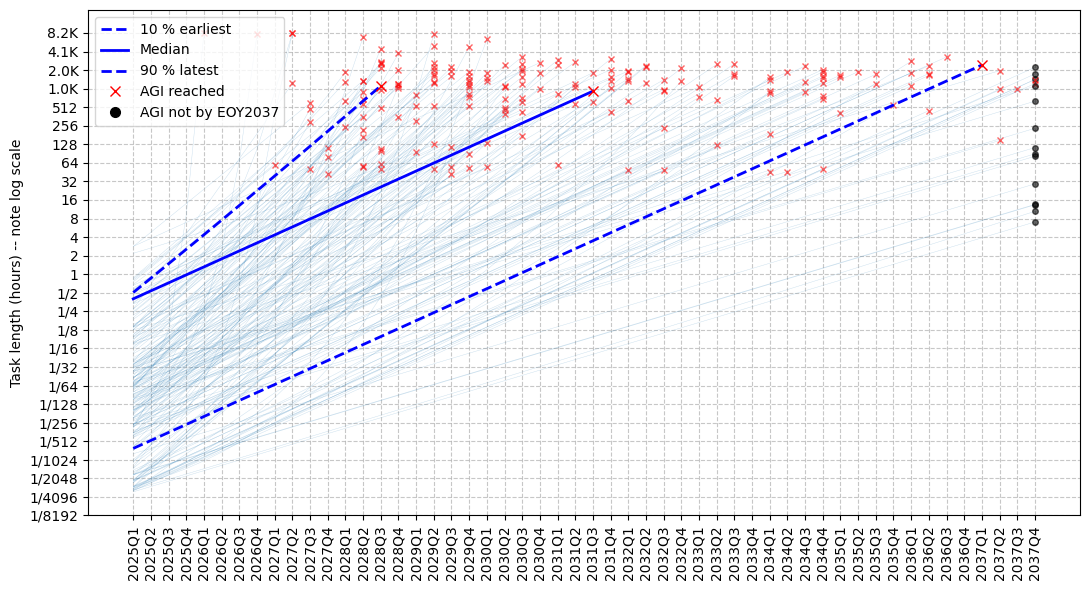

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import squigglepy as sq

DAYS_PER_QUARTER = 365 / 4


def billions_formatter(x, pos):
    if x >= 1e9:
        return f"{x/1e9:.1f}B"
    if x >= 1e6:
        return f"{x/1e6:.1f}M"
    if x >= 1e3:
        return f"{x/1e3:.1f}K"
    if x <= 0.5:
        return f"1/{1/x:.0f}"
    return f"{x:.0f}"


def _quarter_labels(n: int, start_year: int = 2025) -> list[str]:
    return [f"{start_year + q // 4}Q{q % 4 + 1}" for q in range(n + 1)]


def _y_ticks(lo: int = -13, hi: int = 13) -> list[int]:
    return [2 ** k for k in range(lo, hi + 1)]


def _first_curve(order, traj, reference, above):
    cmp = np.greater_equal if above else np.less_equal
    for idx in order:
        if np.all(cmp(traj[idx], reference)):
            return idx
    return order[0]


def plot_exponential_growth(
    doubling_time_days,
    starting_hours,
    agi_task_length,
    shift=0,
    acceleration=1,
    n_quarters: int = 40,
    n_samples: int = 10_000,
    n_traces: int = 100,
) -> None:
    tau0 = sq.sample(doubling_time_days, n=n_samples)
    accel = sq.sample(acceleration, n=n_samples)
    secret = sq.sample(shift, n=n_samples)
    agi = sq.sample(sq.dist_min(2**13, agi_task_length), n=n_samples)
    start = sq.sample(starting_hours, n=n_samples) * 2 ** (secret / tau0)

    quarters = np.arange(n_quarters + 1)
    traj = np.zeros((n_samples, len(quarters)))
    clip_idx = np.full(n_samples, len(quarters), dtype=int)

    for i in range(n_samples):
        tau = tau0[i]
        val = start[i]
        for j in range(len(quarters)):
            if val >= 2**13:
                traj[i, j:] = 2**13
                clip_idx[i] = j
                break
            traj[i, j] = val
            val *= 2 ** (DAYS_PER_QUARTER / tau)
            tau *= accel[i]

    reached = traj >= agi[:, None]
    first_hit = np.argmax(reached, axis=1)
    first_hit[np.all(~reached, axis=1)] = len(quarters)

    order = np.argsort(first_hit)
    median_idx = order[len(order) // 2]
    median_curve = traj[median_idx]

    idx10 = _first_curve(order[int(0.10 * n_samples):], traj, median_curve, above=True)
    idx90 = _first_curve(order[: int(0.90 * n_samples)][::-1], traj, median_curve, above=False)

    highlights = {
        "10 % earliest": (traj[idx10], first_hit[idx10], clip_idx[idx10], "b--"),
        "Median": (median_curve, first_hit[median_idx], clip_idx[median_idx], "b-"),
        "90 % latest": (traj[idx90], first_hit[idx90], clip_idx[idx90], "b--"),
    }

    plt.figure(figsize=(11, 6))
    rng = np.random.default_rng()

    for i in rng.choice(n_samples, min(n_traces, n_samples), replace=False):
        end_q = min(first_hit[i], clip_idx[i], len(quarters) - 1)
        plt.plot(
            quarters[: end_q + 1],
            traj[i, : end_q + 1],
            color="tab:blue",
            lw=0.3,
            alpha=0.25,
        )
        marker = "rx" if first_hit[i] < len(quarters) else "ko"
        plt.plot(quarters[end_q], traj[i, end_q], marker, ms=4, alpha=0.6)

    for label, (curve, hit_q, clip_q, style) in highlights.items():
        end_q = min(hit_q, clip_q, len(quarters) - 1)
        plt.plot(quarters[: end_q + 1], curve[: end_q + 1], style, lw=2, label=label)
        marker = "rx" if hit_q < len(quarters) else "ko"
        plt.plot(quarters[end_q], curve[end_q], marker, ms=7)

    plt.plot([], [], "rx", ms=7, label="AGI reached")
    plt.plot([], [], "ko", ms=7, label="AGI not by EOY2037")

    plt.yscale("log", base=2)
    plt.yticks(_y_ticks())
    plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))
    plt.xticks(quarters, _quarter_labels(n_quarters), rotation=90)
    plt.grid(ls="--", alpha=0.7)
    plt.ylabel("Task length (hours) -- note log scale")
    plt.tight_layout()
    plt.legend(loc="upper left")
    plt.show()
    return None


plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=start_task_length,
    agi_task_length=agi_task_length,
    shift=shift,
    acceleration=acceleration,
    n_quarters=51,
    n_samples=100_000,
    n_traces=200,
)